In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import f1_score

sns.set_theme(context = 'notebook', style = 'darkgrid')

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Métodos de Classificação II

Vamos avançar nossos estudos sobre métodos de classificação analisando dois novos algoritmos (o *Perceptron de Múltiplas Camadas* e os *Modelos de Ensemble*). Além disso teremos o primeiro contato com os conceitos de *underfitting* e *overfitting*, e como esses conceitos se relacionam com a **complexidade** dos modelos de ML.

In [3]:
tb_hotel_train = pd.read_csv("data/tb_hotel_train_clean.csv")
tb_hotel_test = pd.read_csv("data/tb_hotel_test_clean.csv")
tb_hotel_train.head()


,lead_time,adults,children_imp,num_meal,adr,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,...,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company,is_cancelled
0,-0.619738,0.265892,-0.261362,-0.050467,-0.582983,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-0.085516,0.265892,-0.261362,-0.050467,-0.193021,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.507270,0.265892,-0.261362,-0.050467,-1.183915,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.554132,0.265892,-0.261362,-0.050467,-0.319759,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.701759,0.265892,-0.261362,1.856256,-0.310010,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
x_var = ["lead_time", "adr"]
X_train = tb_hotel_train[x_var]
X_test = tb_hotel_test[x_var]
y_train = tb_hotel_train["is_cancelled"]
y_test = tb_hotel_test["is_cancelled"]


Para facilitar a visualização dos nossos modelos continuaremos nos restringindo à duas variáveis: `lead_time` e `adr`. Vamos criar dois DataFrames para visualizar separadamente os efeitos de cada variável sobre **a função de probabilidade** estimada por cada algoritmo:

In [5]:
lead_time_simul = list(np.linspace(-1, 3, 100)) * 3
adr_simul = [-1] * 100 + [0] * 100 + [1] * 100
tb_simul_lt = pd.DataFrame({'lead_time' : lead_time_simul, 'adr' : adr_simul})
tb_simul_lt.head()

,lead_time,adr
0,-1.000000,-1
1,-0.959596,-1
2,-0.919192,-1
3,-0.878788,-1
4,-0.838384,-1


In [6]:
adr_simul = list(np.linspace(-2, 2, 100)) * 3
lead_time_simul = [-1] * 100 + [0] * 100 + [1] * 100
tb_simul_adr = pd.DataFrame({'lead_time' : lead_time_simul, 'adr' : adr_simul})
tb_simul_adr.head()

,lead_time,adr
0,-1,-2.000000
1,-1,-1.959596
2,-1,-1.919192
3,-1,-1.878788
4,-1,-1.838384


Vamos criar um DataFrame com os dados originais de teste para guardarmos as diferentes previsões de nossos modelos:

In [7]:
tb_fits = X_test.copy()
tb_fits["is_cancelled"] = y_test

# Complexidade e Overfitting

Para avaliarmos melhor a relação entre complexidade e overfitting, vamos carregar mais variáveis de nosso dataset:

In [8]:
train_of = pd.read_csv('data/tb_hotel_train_overfit.csv')
test_of = pd.read_csv('data/tb_hotel_test_overfit.csv')

X_train_of = train_of.drop('is_cancelled', axis = 1)
X_test_of = test_of.drop('is_cancelled', axis = 1)
y_train_of = train_of['is_cancelled']
y_test_of = test_of['is_cancelled']

Como vimos no começo do Módulo III, podemos dividir a utilização dos algoritmos de ML em duas etapas:

* **Aprendizagem**, onde o algoritmo *aprende* as relações entre nossas *features* e a *variável resposta* utilizando dados históricos (representados pelo conjunto de treinamento);
* **Predição**, onde utilizamos os padrões *aprendidos* pelo algoritmo para realizar projeções sobre novos dados a partir de nossos *features* (represetado pelo conjunto de teste).

A **fase de aprendizagem** consiste na otimização do erro de projeção sobre o conjunto de treinamento - o modelo ajusta gradualmente seus coeficientes buscando melhorar a cada etapa seu erro de projeção sobre os dados históricos. Conforme aumentamos a **complexidade** do modelo essa otimização torna-se cada vez mais eficiente. 

Isso não significa, necessariamente, que o erro de previsão do modelo melhorará! Conforme a **complexidade** aumenta, o modelo perde a **capacidade de generalização**: ao invés de *encontrar padrões* nos dados históricos ele aprende regras que se aplicam somente às observações do conjunto de treinamento.

Vamos utilizar uma árvore de decisão para visualizar este processo:

In [9]:
from sklearn.tree import DecisionTreeClassifier

As árvores de decisão tem um parâmetro de complexidade muito simples, a **profundida máxima**. Vamos utilizar um `loop for` para construir árvores de decisão de diferentes profundidades e avaliar seu erro sobre o conjunto de treinamento e teste.

In [10]:
max_depth = [int(x) for x in np.linspace(2, 40, 20)]

d_list = []
f1_train_list = []
f1_test_list = []

for d in max_depth:
    rf_fit = DecisionTreeClassifier(max_depth= d)
    rf_fit.fit(X_train_of, y_train_of)
    y_pred_test = rf_fit.predict(X_test_of)
    y_pred_train = rf_fit.predict(X_train_of)

    f1_test = np.round(f1_score(y_test_of, y_pred_test), 4)
    f1_train = np.round(f1_score(y_train_of, y_pred_train), 4)


    d_list.append(d)
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)

In [11]:
tb_rf_fit = pd.DataFrame(
    {
        'depth' : d_list,
        'f1_train' : f1_train_list,
        'f1_test' : f1_test_list
    }
)
tb_rf_fit['diff_error'] = tb_rf_fit['f1_train'] - tb_rf_fit['f1_test']
tb_rf_fit.head(10)

,depth,f1_train,f1_test,diff_error
0,2,0.4797,0.4769,0.0028
1,4,0.6902,0.6849,0.0053
2,6,0.7004,0.6910,0.0094
3,8,0.7386,0.7035,0.0351
4,10,0.7648,0.7072,0.0576
5,12,0.7965,0.6988,0.0977
6,14,0.8435,0.6898,0.1537
7,16,0.8938,0.6811,0.2127
8,18,0.9298,0.6860,0.2438
9,20,0.9490,0.6815,0.2675


Agora vamos comparar a evolução do erro sobre os dois conjuntos, teste e treinamento, para visualizar o impacto da complexidade (representada pela profundidade) sobre underfitting/overfitting

<Axes: xlabel='depth', ylabel='f1_train'>

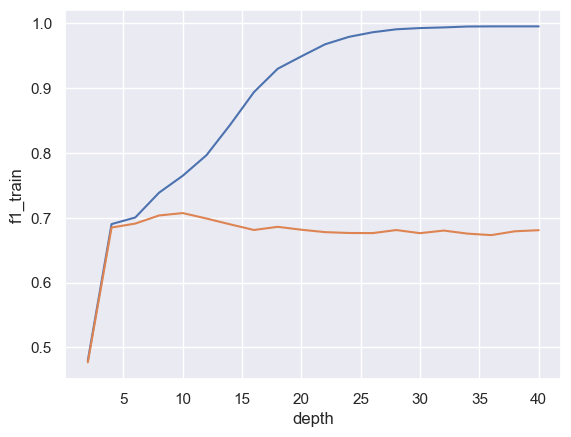

In [12]:
sns.lineplot(data = tb_rf_fit, x = 'depth', y = 'f1_train')
sns.lineplot(data = tb_rf_fit, x = 'depth', y = 'f1_test')

## Relação entre Tradeoff Viés-Variância e Overfitting

O tradeoff viés-variância está intimamente relacionado ao problema de overfitting em aprendizado de máquina.

- **Viés** refere-se ao erro introduzido ao aproximar um problema do mundo real com um modelo simplificado. Isso significa que um modelo com alto viés é provavelmente fazer suposições incorretas sobre as relações subjacentes nos dados, levando a underfitting e baixo desempenho preditivo.

- **Variância** refere-se à quantidade pela qual as previsões de um modelo mudariam se fosse treinado em um conjunto diferente de dados. Um modelo com alta variância é provavelmente capturar ruídos aleatórios nos dados de treinamento, levando a overfitting e má generalização para novos dados.

O tradeoff entre viés e variância surge porque modelos com mais complexidade podem ajustar os dados de treinamento mais precisamente (reduzindo o viés), mas são mais propensos a overfitting (aumentando a variância). Da mesma forma, modelos com menos complexidade são menos propensos a overfitting, mas podem não capturar todos os padrões relevantes nos dados (aumentando o viés).

Overfitting ocorre quando um modelo é muito complexo em relação à quantidade de dados de treinamento disponíveis, resultando em um modelo que ajusta os dados de treinamento muito bem, mas generaliza mal para novos dados não vistos. 

Técnicas de ensembling como bagging e boosting também podem ajudar a reduzir o overfitting, combinando vários modelos que são menos propensos a overfitting do que um único modelo mais complexo. 

- **Bagging** é uma técnica de ensemble que combina vários modelos independentes, treinados em diferentes subconjuntos aleatórios do conjunto de dados original. Isso reduz a variância do modelo final, porque cada modelo é treinado em um conjunto de dados diferente, tornando o modelo final menos suscetível a ruído aleatório no conjunto de dados.

- **Boosting** é uma técnica de ensemble que combina vários modelos fracos em um modelo forte. Ao contrário do bagging, que treina modelos independentes, o boosting treina cada modelo sequencialmente, dando mais peso aos exemplos de treinamento que foram classificados incorretamente pelo modelo anterior. Isso ajuda a reduzir o viés do modelo final, porque cada modelo subsequente é treinado para corrigir os erros do modelo anterior.

## Técnicas de Ensemble

Ensemble é uma técnica de aprendizado de máquina que combina vários modelos diferentes para melhorar a precisão e a robustez das previsões.

### Bagging

Bagging (Bootstrap Aggregating) foi proposto por Leo Breiman em 1996 como uma técnica para reduzir a variância dos modelos e evitar o overfitting. 

A ideia por trás do bagging é:
- criar várias instâncias do modelo base (por exemplo, árvore de decisão) treinando cada uma em uma amostra diferente do conjunto de dados de treinamento.
- selecionar essas amostras com substituição (bootstrap), o que significa que cada amostra é uma seleção aleatória do conjunto de dados de treinamento original.
- combinar as previsões de cada modelo por meio de votação para gerar uma única previsão final.

O bagging reduz a variância porque:
- as instâncias do modelo base treinadas em diferentes amostras de dados tendem a produzir previsões ligeiramente diferentes.
- a votação ajuda a combinar essas previsões em uma única previsão mais robusta.

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf_fit = RandomForestClassifier(n_estimators = 1500, max_depth= 3)
rf_fit.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=1500)

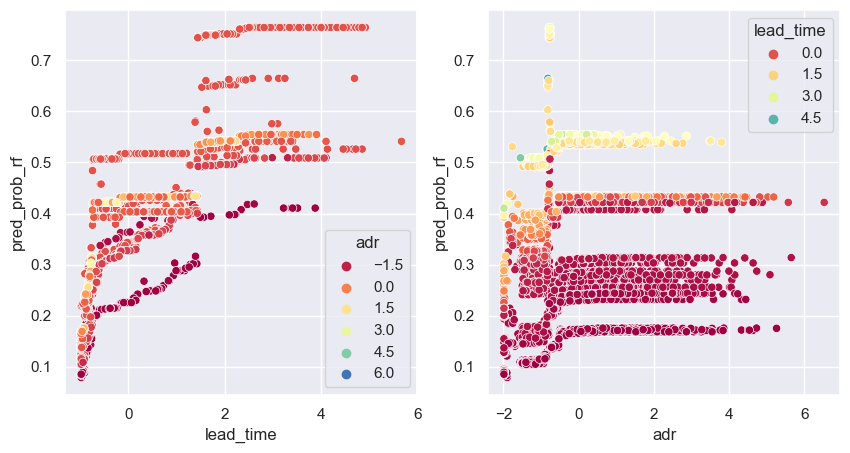

In [24]:
tb_fits["pred_prob_rf"] = rf_fit.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(
    data=tb_fits, 
    x="lead_time", y="pred_prob_rf", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.scatterplot(
    data=tb_fits, 
    x="adr", y="pred_prob_rf", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');



<Axes: >

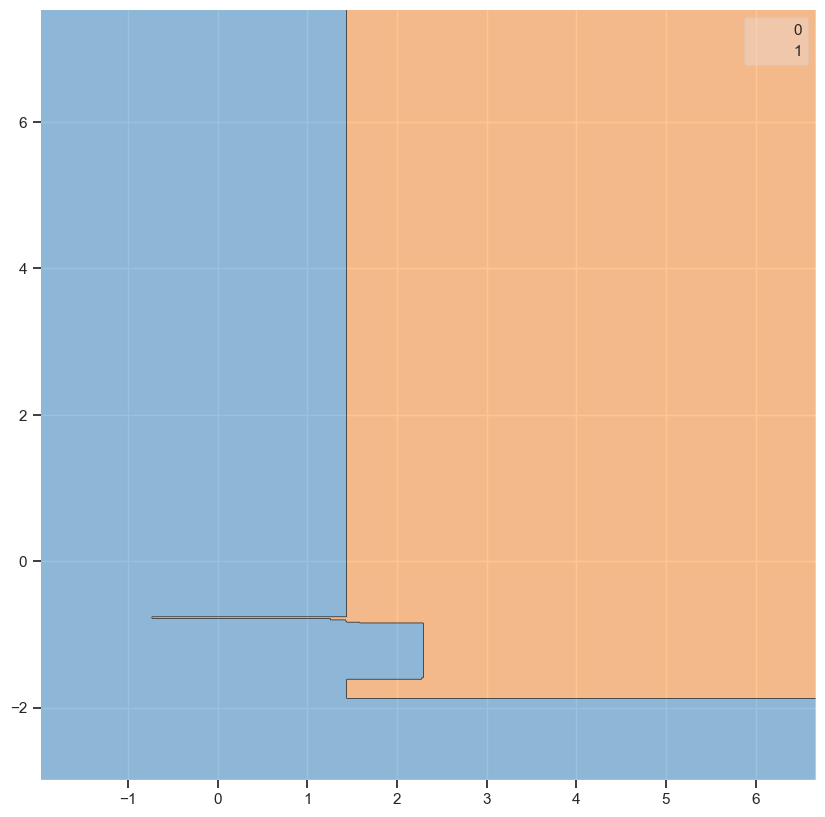

In [25]:
fig = plt.figure(figsize=(10, 10))
plot_decision_regions(
    np.array(tb_fits[["lead_time", "adr"]),
    np.array(tb_fits["is_cancelled"]),
    rf_fit,
    scatter_kwargs={"alpha": 0.001},
)


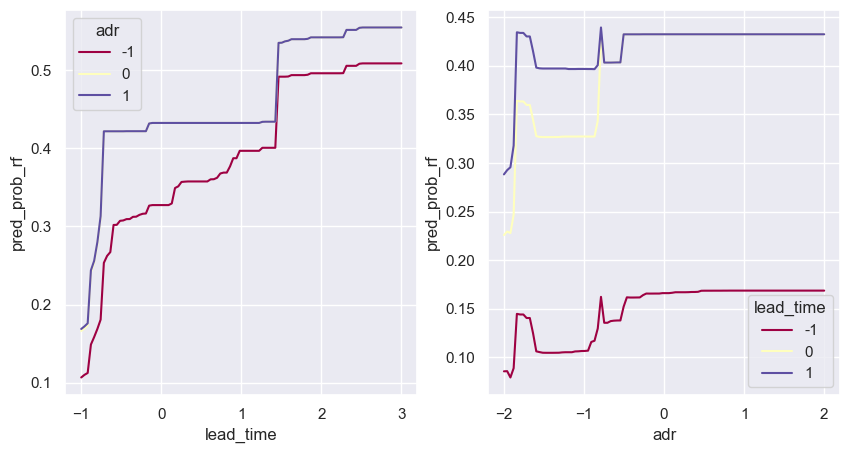

In [26]:
tb_simul_lt['pred_prob_rf'] = rf_fit.predict_proba(tb_simul_lt[x_var])[:,1]
tb_simul_adr['pred_prob_rf'] = rf_fit.predict_proba(tb_simul_adr[x_var])[:,1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.lineplot(
    data=tb_simul_lt, 
    x="lead_time", y="pred_prob_rf", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.lineplot(
    data=tb_simul_adr, 
    x="adr", y="pred_prob_rf", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');


### Boosting

Boosting foi proposto por Robert Schapire em 1990 e posteriormente desenvolvido por Yoav Freund e outros pesquisadores. 

O objetivo do boosting é melhorar a precisão do modelo base, enfatizando os exemplos de treinamento que foram mal previstos. 

A ideia é:
- treinar vários modelos fracos (por exemplo, uma árvore de decisão rasa) em diferentes subconjuntos dos dados de treinamento.
- atribuir pesos aos exemplos de treinamento com base em quão bem o modelo previu esses exemplos.
- os exemplos mal previstos recebem um peso maior, de modo que o modelo seguinte seja mais focado nesses exemplos e possa corrigir os erros anteriores.
- a previsão final é feita por meio da combinação das previsões de todos os modelos com base em seus pesos.

O boosting reduz o viés do modelo base, tornando-o mais preciso.

In [27]:
from catboost import CatBoostClassifier

In [28]:
cat_fit = CatBoostClassifier(
    iterations = 500, depth=4
    )
cat_fit.fit(X_train, y_train, eval_set = (X_test, y_test))

Learning rate set to 0.127949
0:	learn: 0.6678033	test: 0.6677585	best: 0.6677585 (0)	total: 63.6ms	remaining: 31.7s
1:	learn: 0.6488532	test: 0.6486484	best: 0.6486484 (1)	total: 70.2ms	remaining: 17.5s
2:	learn: 0.6346967	test: 0.6343483	best: 0.6343483 (2)	total: 76.5ms	remaining: 12.7s
3:	learn: 0.6233480	test: 0.6223815	best: 0.6223815 (3)	total: 83.1ms	remaining: 10.3s
4:	learn: 0.6150171	test: 0.6140393	best: 0.6140393 (4)	total: 89.3ms	remaining: 8.85s
5:	learn: 0.6086765	test: 0.6075711	best: 0.6075711 (5)	total: 95.2ms	remaining: 7.83s
6:	learn: 0.6039746	test: 0.6028353	best: 0.6028353 (6)	total: 102ms	remaining: 7.19s
7:	learn: 0.6003932	test: 0.5991870	best: 0.5991870 (7)	total: 108ms	remaining: 6.67s
8:	learn: 0.5969329	test: 0.5952029	best: 0.5952029 (8)	total: 115ms	remaining: 6.28s
9:	learn: 0.5947102	test: 0.5929283	best: 0.5929283 (9)	total: 122ms	remaining: 5.96s
10:	learn: 0.5931032	test: 0.5913886	best: 0.5913886 (10)	total: 127ms	remaining: 5.65s
11:	learn: 0.591

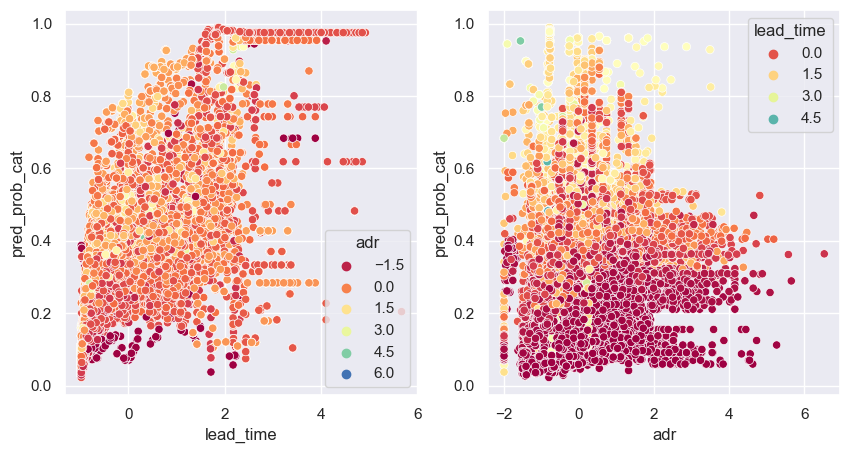

In [29]:
tb_fits["pred_prob_cat"] = cat_fit.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(
    data=tb_fits, 
    x="lead_time", y="pred_prob_cat", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.scatterplot(
    data=tb_fits, 
    x="adr", y="pred_prob_cat", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');

<Axes: >

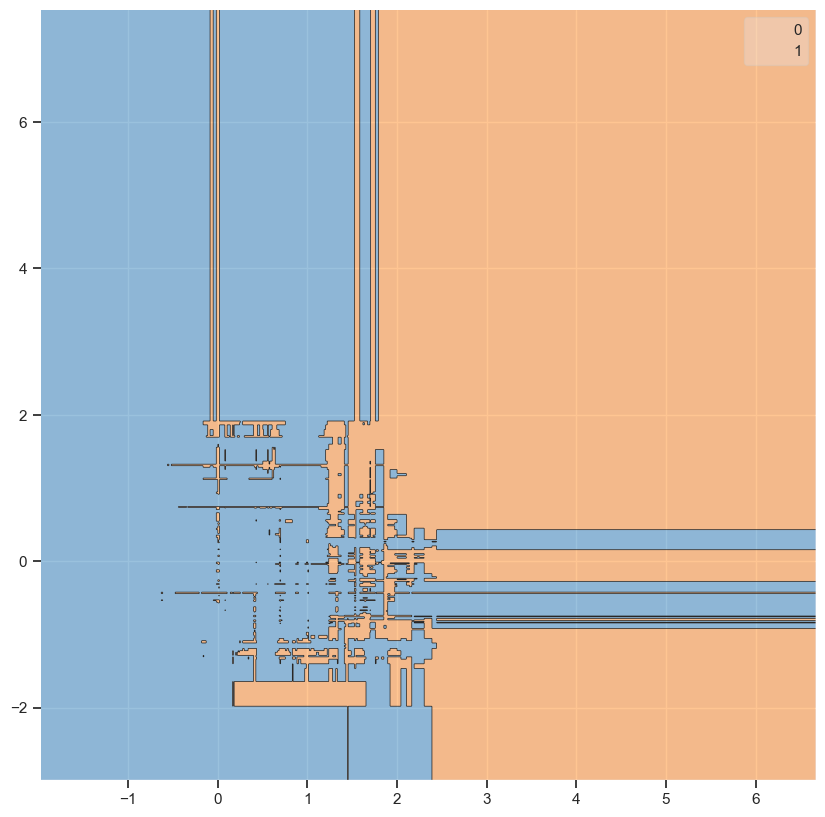

In [30]:
fig = plt.figure(figsize=(10, 10))
plot_decision_regions(
    np.array(tb_fits[["lead_time", "adr"]]),
    np.array(tb_fits["is_cancelled"]),
    cat_fit,
    scatter_kwargs={"alpha": 0.001},
)


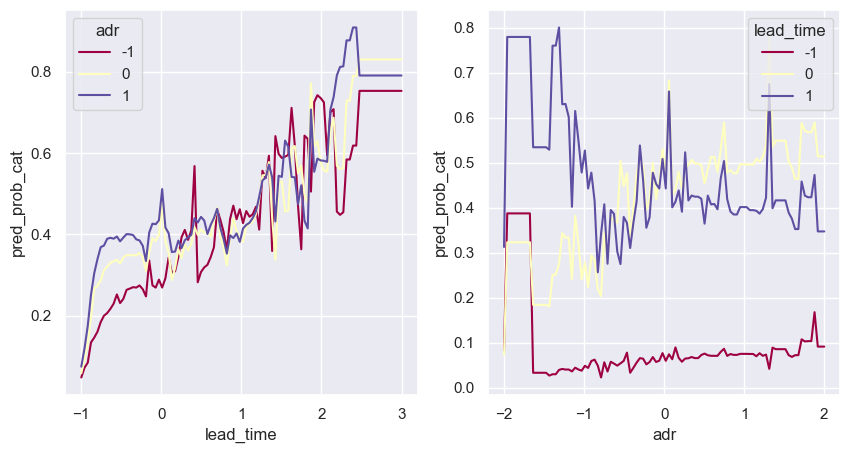

In [31]:
tb_simul_lt['pred_prob_cat'] = cat_fit.predict_proba(tb_simul_lt[x_var])[:,1]
tb_simul_adr['pred_prob_cat'] = cat_fit.predict_proba(tb_simul_adr[x_var])[:,1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.lineplot(
    data=tb_simul_lt, 
    x="lead_time", y="pred_prob_cat", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.lineplot(
    data=tb_simul_adr, 
    x="adr", y="pred_prob_cat", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');

### Escolha entre Bagging e Boosting

Em geral, o bagging é preferido quando o modelo base é propenso a overfitting, enquanto o boosting é preferido quando o modelo base é muito simples e tem alto viés.

Ambas as técnicas são muito usadas em problemas de aprendizado de máquina e continuam sendo áreas ativas de pesquisa.